## Import và Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms,datasets
from torchvision.transforms import InterpolationMode

import random

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

# Kiểm tra thiết bị (GPU hay CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


## Data Augmentation

In [2]:
img_height, img_width = 350, 350 

data_transforms = {
    'train': transforms.Compose([
        # Resize
        transforms.Resize(
            (img_height, img_width),
            interpolation=InterpolationMode.BILINEAR
        ),

        # Flip
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),

        # Affine = rotation + shift + zoom
        transforms.RandomAffine(
            degrees=10,                     # rotation_range=10
            translate=(0.05, 0.05),         # width/height_shift=0.05
            scale=(0.95, 1.05),             # zoom_range=0.05
            shear=0,                        # shear_range=0
            interpolation=InterpolationMode.BILINEAR,
            fill=0                         
        ),

        # Brightness
        transforms.ColorJitter(
            brightness=0.1                  # brightness_range=[0.9,1.1]
        ),

        # Tensor + Normalize
        transforms.ToTensor(),              # = rescale 1/255
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])
}


## Load Data

In [3]:
data_dir = '/kaggle/input/bean-leaf-lesions-classification'

#Dictionary chứa 2 ImageFolder datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
# DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=2)
}

train_loader = dataloaders['train']
val_loader = dataloaders['val']

# Đếm số lượng ảnh trong mỗi tập
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Lấy danh sách tên classes
class_names = image_datasets['train'].classes
# Lấy mapping từ class name sang index
class_to_idx = image_datasets['train'].class_to_idx  

print(f"Classes: {class_names}")
print(f"Số lượng ảnh Train: {dataset_sizes['train']}")
print(f"Số lượng ảnh Val: {dataset_sizes['val']}")

Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Số lượng ảnh Train: 1034
Số lượng ảnh Val: 133


## Build Model

In [4]:
# EFFICIENTNET-B3 (TRANSFER LEARNING)
def build_model(num_classes):
    
    # Tải model EfficientNet-B3 đã pre-trained
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

    # Unfreeze các layers (cho phép fine-tuning)
    for param in model.features.parameters():
        param.requires_grad = True 

    # Thay thế lớp Classifier cuối cùng
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model

# Khởi tạo model
model = build_model(num_classes=len(class_names))
model = model.to(device)

print("Model EfficientNetB3 đã được khởi tạo")
print(f"Số lớp output: {len(class_names)}")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 186MB/s]


Model EfficientNetB3 đã được khởi tạo
Số lớp output: 3


## Early Stopping

In [5]:
# EARLY STOPPING
class EarlyStopping:
    
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        # Epoch đầu tiên 
        if self.best_score is None:
            self.best_score = score 
            self.save_checkpoint(val_loss, model)
            
        # Score hiện tại KHÔNG tốt hơn best
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
        # Score hiện tại TỐT HƠN best
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## CONFIG Optimizer

In [6]:
# Hàm mất mát: CrossEntropyLoss 
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

## Training Functions

In [7]:
# Training Function
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Validation Function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

## Training Loop

In [8]:
NUM_EPOCHS = 30

# Khởi tạo Early Stopping
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth')

# Lưu trữ metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("=" * 60)
print("BẮT ĐẦU HUẤN LUYỆN")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("\n Early stopping triggered!")
        break

print("\n" + "=" * 60)
print("HOÀN THÀNH HUẤN LUYỆN")
print("=" * 60)

BẮT ĐẦU HUẤN LUYỆN

Epoch 1/30
----------------------------------------
Train Loss: 0.6103 | Train Acc: 0.7689
Val Loss:   0.1617 | Val Acc:   0.9398
Validation loss decreased (inf → 0.161660). Saving model...

Epoch 2/30
----------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.1275 | Train Acc: 0.9642
Val Loss:   0.1202 | Val Acc:   0.9549
Validation loss decreased (0.161660 → 0.120184). Saving model...

Epoch 3/30
----------------------------------------
Train Loss: 0.0564 | Train Acc: 0.9836
Val Loss:   0.1947 | Val Acc:   0.9323
EarlyStopping counter: 1/5

Epoch 4/30
----------------------------------------
Train Loss: 0.0450 | Train Acc: 0.9845
Val Loss:   0.0712 | Val Acc:   0.9699
Validation loss decreased (0.120184 → 0.071155). Saving model...

Epoch 5/30
----------------------------------------
Train Loss: 0.0562 | Train Acc: 0.9836
Val Loss:   0.0562 | Val Acc:   0.9774
Validation loss decreased (0.071155 → 0.056239). Saving model...

Epoch 6/30
----------------------------------------
Train Loss: 0.0241 | Train Acc: 0.9913
Val Loss:   0.0336 | Val Acc:   0.9850
Validation loss decreased (0.056239 → 0.033612). Saving model...

Epoch 7/30
----------------------------------------
Train Loss: 0.0273 | Train Acc: 0.9923
Val Loss:   0.0629 

## Đánh giá

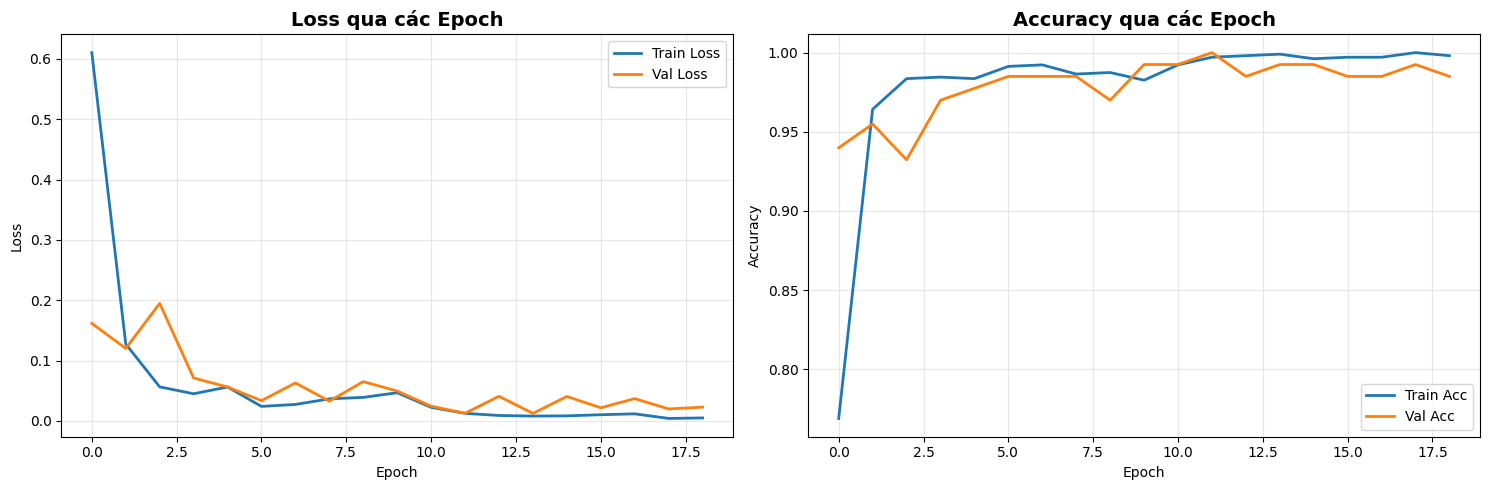

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_title('Loss qua các Epoch', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc', linewidth=2)
axes[1].plot(val_accs, label='Val Acc', linewidth=2)
axes[1].set_title('Accuracy qua các Epoch', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Best model loaded!

VALIDATION SET - CLASSIFICATION REPORT
                   precision    recall  f1-score   support

angular_leaf_spot       1.00      0.98      0.99        44
        bean_rust       0.98      1.00      0.99        45
          healthy       1.00      1.00      1.00        44

         accuracy                           0.99       133
        macro avg       0.99      0.99      0.99       133
     weighted avg       0.99      0.99      0.99       133



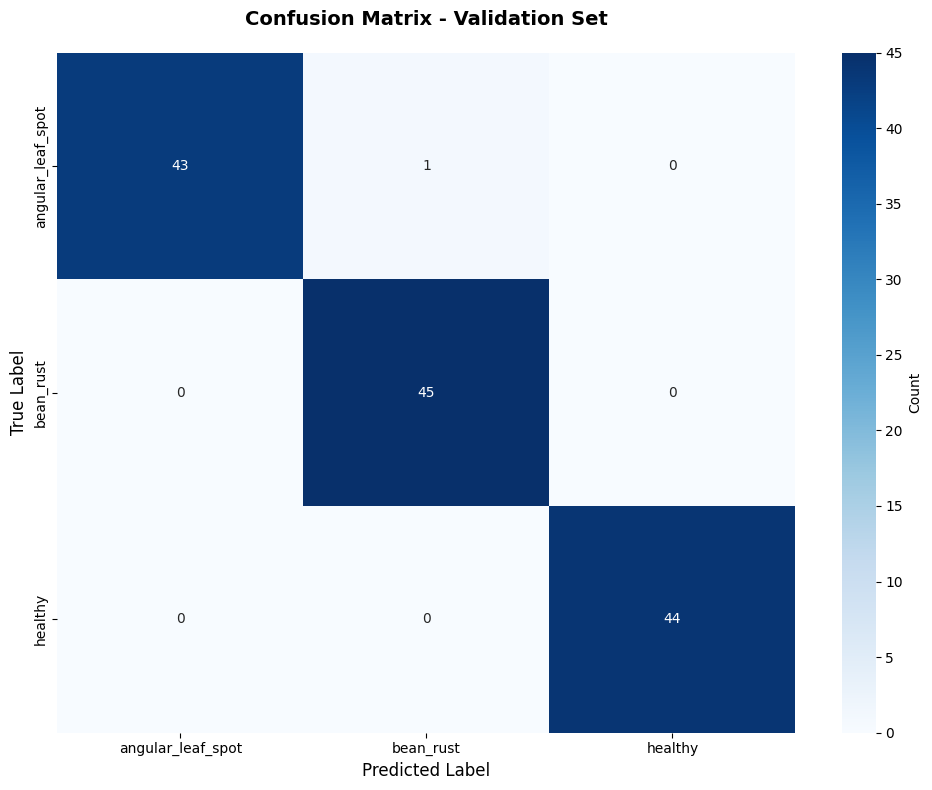

In [10]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("Best model loaded!\n")

# Đánh giá trên Validation Set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print("=" * 60)
print("VALIDATION SET - CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=list(class_to_idx.keys()),
    digits=2
))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=list(class_to_idx.keys()),
    yticklabels=list(class_to_idx.keys()),
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-nxauvpep
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-nxauvpep
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=37c0af921b52e4a5c5245672c4ed0fdf2f3945abff01d22676b6b43286154385
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wqx7qdg/wheels/69/29/f7/3abdb24031a22af044df15784c8a00f56b6e24f5924e33d0e8
Successfully built grad-cam


Cảnh báo: Không tìm thấy file checkpoint nào!
Đang tìm ảnh đại diện cho từng lớp bệnh...


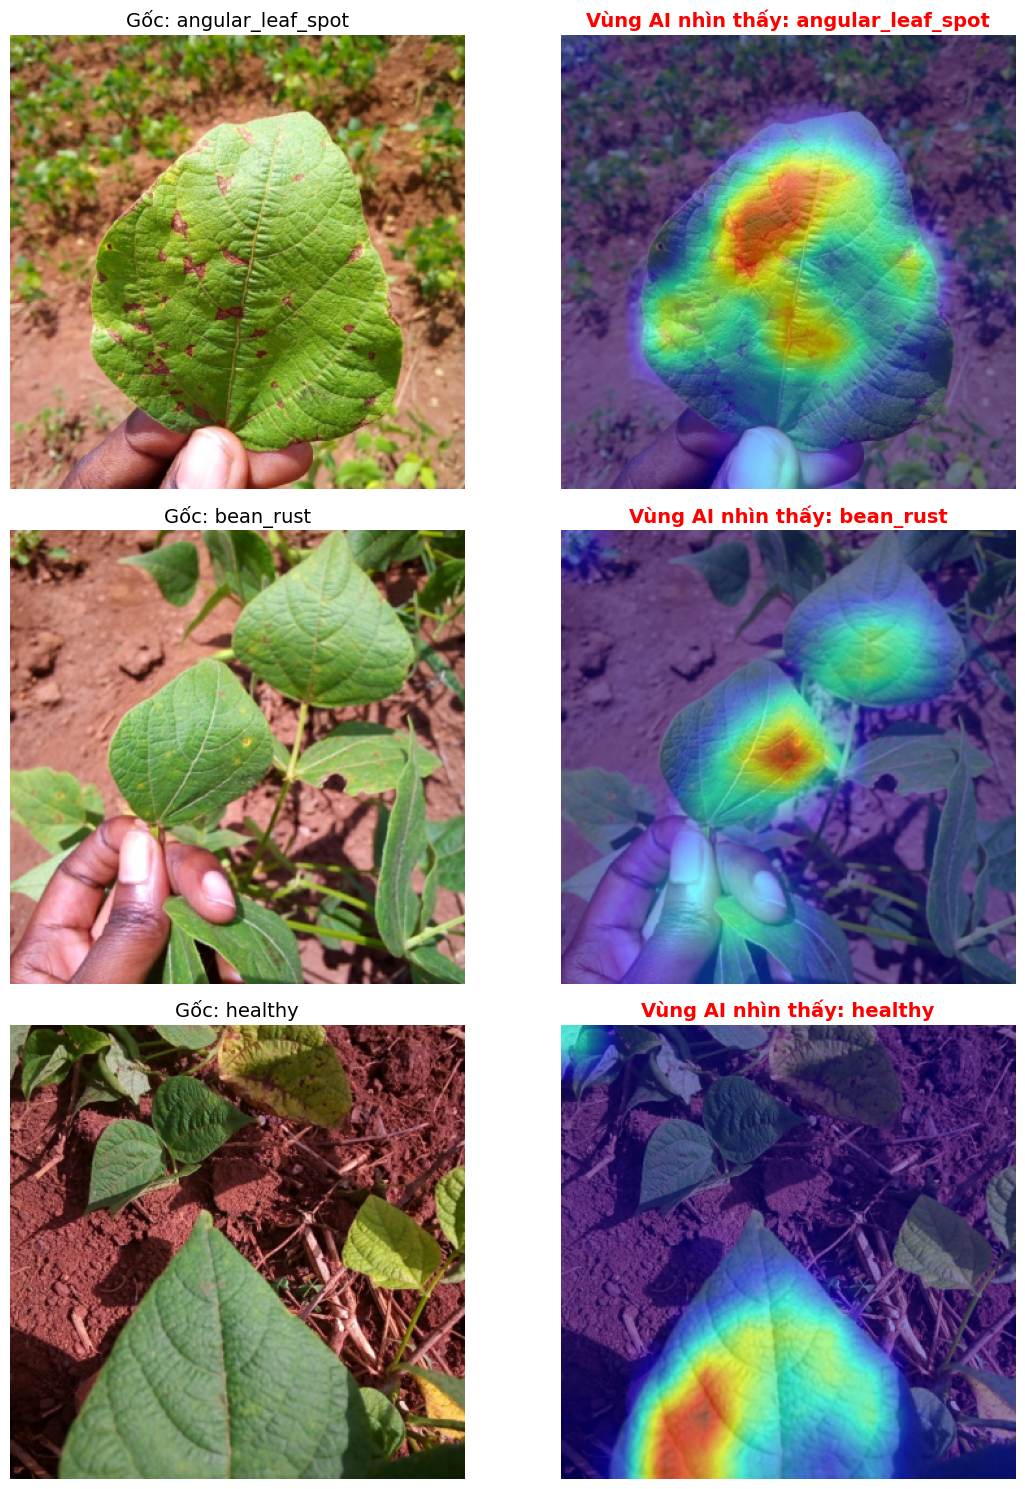

In [12]:
# GRADCAM: HIỂN THỊ VÙNG BỆNH MÔ HÌNH TẬP TRUNG NHÌN VÀO
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

def visualize_bean_leaf_gradcam(model, dataset, device):
    """
    Hàm hiển thị GradCAM cho bài toán Bean Leaf Lesions
    """
    model.eval()
    
    # Định nghĩa các lớp cần tìm (0: angular_leaf_spot, 1: bean_rust, 2: healthy)
    required_labels = {0, 1, 2}
    found_indices = {}
    
    print("Đang tìm ảnh đại diện cho từng lớp bệnh...")
    
    # Duyệt ngẫu nhiên hoặc tuần tự để tìm đủ 1 ảnh cho mỗi lớp
    # Dùng try-except để xử lý các loại dataset khác nhau
    limit = min(len(dataset), 1000)
    for i in range(limit):
        try:

            data_item = dataset[i]
            if len(data_item) == 2:
                _, label = data_item
            elif len(data_item) == 3:
                _, _, label = data_item 
            
            # Xử lý label về dạng int
            if isinstance(label, torch.Tensor):
                label_idx = label.item()
            else:
                label_idx = int(label)
                
            if label_idx in required_labels and label_idx not in found_indices:
                found_indices[label_idx] = i
                
            if len(found_indices) == 3: # Đã tìm đủ 3 lớp
                break
        except Exception as e:
            continue

    if len(found_indices) == 0:
        print(" Lỗi: Không tìm thấy ảnh trong dataset.")
        return

    # Lấy tên class chuẩn
    class_names = ['angular_leaf_spot', 'bean_rust', 'healthy']

    # Thiết lập biểu đồ
    fig, axes = plt.subplots(nrows=len(found_indices), ncols=2, figsize=(12, 5 * len(found_indices)))
    
    target_layers = []
    if hasattr(model, 'block6'): 
         target_layers = [model.block6.conv2] 
    elif hasattr(model, 'block5'):
        target_layers = [model.block5.conv2]
    elif hasattr(model, 'features'):
        target_layers = [model.features[-1]] # Cho VGG/MobileNet
    elif hasattr(model, 'layer4'):
        target_layers = [model.layer4[-1]] # Cho ResNet
    else:
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                target_layers = [module]

    # Khởi tạo GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Các thông số Normalize của ImageNet 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])


    for row_idx, (label_idx, index) in enumerate(sorted(found_indices.items())):
        # Lấy ảnh
        data_item = dataset[index]
        img_tensor = data_item[0] # Giả định phần tử đầu tiên luôn là ảnh
        
        class_name = class_names[label_idx]
        
        # --- Chạy GradCAM ---
        input_tensor = img_tensor.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(label_idx)]
        
        # Tạo mask grayscale
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        # --- Denormalize ảnh để hiển thị màu gốc ---
        # Chuyển từ Tensor [C, H, W] sang Numpy [H, W, C]
        rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
        # Công thức: img * std + mean
        rgb_img = rgb_img * std + mean
        rgb_img = np.clip(rgb_img, 0, 1) # Đảm bảo pixel trong khoảng [0, 1]
        
        # --- Chồng Heatmap lên ảnh ---
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        # Hiển thị lên subplot
        ax_orig = axes[row_idx][0] if len(found_indices) > 1 else axes[0]
        ax_cam = axes[row_idx][1] if len(found_indices) > 1 else axes[1]
        
        ax_orig.imshow(rgb_img)
        ax_orig.set_title(f"Gốc: {class_name}", fontsize=14)
        ax_orig.axis('off')
        
        ax_cam.imshow(visualization)
        ax_cam.set_title(f"Vùng AI nhìn thấy: {class_name}", fontsize=14, color='red', fontweight='bold')
        ax_cam.axis('off')

    plt.tight_layout()
    plt.show()

checkpoint_path = 'best_model.pth' 
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Đã load thành công model từ: {checkpoint_path}")
else:
    if os.path.exists('best_model_fold1.pth'):
        model.load_state_dict(torch.load('best_model_fold1.pth'))
        print("Đã load model từ best_model_fold1.pth")
    else:
        print("Cảnh báo: Không tìm thấy file checkpoint nào!")

visualize_bean_leaf_gradcam(model, image_datasets['val'], device)

In [15]:
from tqdm import tqdm
def save_dataset_gradcams(model, dataset, device, base_output_dir, subset_name):
    """
    Chạy GradCAM và lưu ảnh visualize cho toàn bộ dataset.
    """
    model.eval()
    
    # Tạo đường dẫn lưu: base_output_dir/subset_name (vd: gradcam_results/val)
    output_dir = os.path.join(base_output_dir, subset_name)
    
    # Lấy tên class từ dataset
    if hasattr(dataset, 'classes'):
        class_names = dataset.classes
    else:
        # Fallback nếu không lấy được attribute classes
        class_names = ['angular_leaf_spot', 'bean_rust', 'healthy']
    
    # Tạo thư mục con cho từng class
    for class_name in class_names:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)
            
    print(f"\n>>> Đang xử lý tập: {subset_name.upper()} ({len(dataset)} ảnh)")
    print(f"    Lưu tại: {output_dir}")

    if hasattr(model, 'features'):
        target_layers = [model.features[-1]]
    else:
        # Fallback tự động tìm Conv2d cuối cùng
        target_layers = []
        for module in model.modules():
            if isinstance(module, torch.nn.Conv2d):
                target_layers = [module]
        target_layers = [target_layers[-1]] if target_layers else []
        
    print(f"    Target Layer: {target_layers}")

    # Khởi tạo GradCAM
    use_cuda = True if str(device) == 'cuda' else False
    cam = GradCAM(model=model, target_layers=target_layers)

    # Thông số Normalize chuẩn ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Duyệt qua từng ảnh trong dataset
    for i in tqdm(range(len(dataset)), desc=f"Processing {subset_name}"):
        try:
            # Lấy dữ liệu: img_tensor (3, H, W), label (int)
            data_item = dataset[i]
            img_tensor = data_item[0]
            label = data_item[1]

            if isinstance(label, torch.Tensor):
                label_idx = label.item()
            else:
                label_idx = int(label)
            
            class_name = class_names[label_idx]

            # --- GradCAM Core ---
            # Thêm batch dimension: (1, 3, H, W)
            input_tensor = img_tensor.unsqueeze(0).to(device)
            
            # Target: Soi vào class thực tế (Ground Truth) để xem model có nhìn đúng chỗ không
            targets = [ClassifierOutputTarget(label_idx)] 

            # Sinh heatmap
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :] # Lấy ảnh đầu tiên trong batch

            # --- Xử lý ảnh để lưu ---
            # Denormalize ảnh gốc để hiển thị màu sắc chuẩn
            rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
            rgb_img = rgb_img * std + mean
            rgb_img = np.clip(rgb_img, 0, 1)
            
            # Chồng heatmap lên ảnh gốc
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            
            # Lưu ảnh
            # Đặt tên file: subset_index.jpg (vd: val_0001.jpg)
            save_path = os.path.join(output_dir, class_name, f"{subset_name}_{i:04d}.jpg")
            Image.fromarray(visualization).save(save_path)

        except Exception as e:
            print(f"Lỗi tại index {i}: {e}")
            continue


# Load Model Tốt Nhất
model = build_model(num_classes=len(class_names)).to(device)

checkpoint_path = 'best_model.pth'
if os.path.exists('best_model.pth'):
    checkpoint_path = 'best_model.pth'
    
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Đã load checkpoint: {checkpoint_path}")
else:
    print(" Cảnh báo: Không tìm thấy checkpoint! Sử dụng model khởi tạo ngẫu nhiên.")


viz_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['val'])
viz_val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

ROOT_OUTPUT = 'gradcam_full_results'

# Chạy GradCAM
# Chạy cho tập Validation
save_dataset_gradcams(model, viz_val_dataset, device, ROOT_OUTPUT, 'val')

# Chạy cho tập Training
save_dataset_gradcams(model, viz_train_dataset, device, ROOT_OUTPUT, 'train')


Đã load checkpoint: best_model.pth

>>> Đang xử lý tập: VAL (133 ảnh)
    Lưu tại: gradcam_full_results/val
    Target Layer: [Conv2dNormActivation(
  (0): Conv2d(384, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)]


Processing val: 100%|██████████| 133/133 [00:08<00:00, 14.85it/s]



>>> Đang xử lý tập: TRAIN (1034 ảnh)
    Lưu tại: gradcam_full_results/train
    Target Layer: [Conv2dNormActivation(
  (0): Conv2d(384, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)]


Processing train: 100%|██████████| 1034/1034 [01:09<00:00, 14.85it/s]


In [16]:
import shutil
import os
from IPython.display import FileLink

# Tên thư mục kết quả đang có
folder_to_zip = 'gradcam_full_results'
# Tên file zip muốn tạo ra (không cần đuôi .zip)
output_filename = 'ket_qua_gradcam'

# 1. Nén thư mục
if os.path.exists(folder_to_zip):
    print(" Đang nén file... Vui lòng chờ chút.")
    shutil.make_archive(output_filename, 'zip', folder_to_zip)
    zip_path = f"{output_filename}.zip"
    print(f" Đã nén xong: {zip_path}")
    
    # 2. Tạo đường dẫn tải xuống (Click vào link hiện ra bên dưới)
    print("Click vào link dưới đây để tải về:")
    display(FileLink(zip_path))
else:
    print(f"Không tìm thấy thư mục {folder_to_zip}")

 Đang nén file... Vui lòng chờ chút.
 Đã nén xong: ket_qua_gradcam.zip
Click vào link dưới đây để tải về:


/kaggle/working/ket_qua_gradcam.zip